# Wavefront Propagation and PSF simulation with Scoob
The scoobPSF package builds a layer on-top of poppy that is specific to the scoob optical bench.
This notebook demonstrates how to simulate monochromatic PSFs and wavefronts with the scoobPSF package. <br>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoobm

## Optical System Parameters
the following cell sets key model parameters

In [4]:
pupil_diam = 6.75*u.mm 
lyot_diam=3.6*u.mm
det_rotation = 20 #  degrees of rotation of the detector relative to the optical axis

# The flattest wavefront obtained for the system in the lab by
# performing phase diversity
dm_flat = fits.getdata(scoobm.module_path/'scoob_dm_flat.fits')

## Simulation Parameters
npix and oversample are divided by 4 to increase speed at the expense of accuracy

In [5]:
wavelength_c = 632.8e-9*u.m # central wavelength
npix=512
oversample=8
use_opds=False #  Incorporate WFE from each optical component
fpm=None
lyot=None

## Declare the coronograph setup
Note that by default, the coronograph is not installed when the class gets instantiated.

In [6]:
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)

#### Optional: Use the knife edge as a FPM
Knife edge shifted to 2 lambda/D.<br>
Note that he f/# at the FPM is 48.

In [7]:
shift = (2 * wavelength_c * 48).to("um")
knife_edge = poppy.KnifeEdge(name='Knife Edge', rotation=0, shift_x=-shift)

## Initialize the class with the appropriate parameters for a non-coronographic PSF

In [27]:
reload(scoobm)
model = scoobm.SCOOBM(npix=npix, 
                      oversample=oversample, 
                      wavelength=wavelength_c, 
                      pupil_diam=pupil_diam,
                      det_rotation=det_rotation, 
                      use_synthetic_opds=use_opds,
                      FPM=fpm,
                      LYOT=lyot,
                     )

## Run the propagation to determine the normalization constant

Set the dm to provide the flattest wavefront obtained in the lab. <br>
Run the simulation to produce the PSF image.

In [20]:
True or False

True

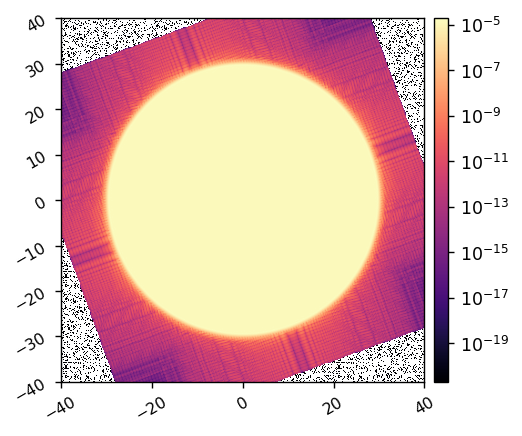

In [28]:
model.set_dm(dm_flat)

ref_im = model.snap()
imshow1(ref_im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

Set the normalization constant, which is used when calculating all future PSFS. <br>
Then, repropogate and normalize the image based on the peak of the PSF and re-display

In [ ]:
model.imnorm = ref_im.max()

normalized_im = model.snap()
imshow1(normalized_im, lognorm=True, vmin=1e-7, pxscl=model.psf_pixelscale_lamD)

## Create Coronographic PSFs
Start by setting the coronograph parameters in the model

In [ ]:
model.FPM = vortex
# model.FPM = knife_edge
model.LYOT = lyot_stop

Calculate the PSF, which will be normalized by the non-conographic PSF intensity determined before.

In [ ]:
# model.reset_dm()
# model.zero_dm()

im = model.snap()
imshow1(im, lognorm=True, vmin=1e-12, pxscl=model.psf_pixelscale_lamD)

## Calculation of Wavefronts at each optic/plane
The calc_wfs method can be used to calculate the wavefront at each plane.<br>

In [ ]:
# model.FPM = None
# model.LYOT = None

wfs = model.calc_wfs()

Display the focal plane

In [ ]:
imshow2(wfs[-1].intensity, wfs[-1].phase,
            f"Intensity {wfs[-1].location}",
            f"Phase {wfs[-1].location}",
            lognorm1=True, 
            pxscl=model.psf_pixelscale_lamD)

View the intensity and phase at each surface

In [ ]:
for i,wf in enumerate(wfs):
    imshow2(wf.intensity, wf.phase,
            f"Intensity {wf.location}",
            f"Phase {wf.location}",
            lognorm1=True,
            pxscl=wf.pixelscale.to_value(u.mm/u.pix), 
            xlabel='$mm$')